In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline


In [28]:
# iris dataset downloaded from standard sklearn dataset libraries
iris_dataset = sklearn.datasets.load_iris()


# Extrated only two features from iris dataset (sum of every two features)
# the reason is simplified visualisation
X = np.array(list(map(lambda x: [x[0] + x[1], x[2] + x[3]], iris_dataset['data'])))
Y = iris_dataset['target']

"Shape of dataset", X.shape, Y.shape

('Shape of dataset', (150, 2), (150,))

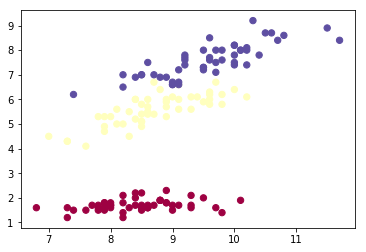

In [30]:
plt.scatter(X[:,0], X[:,1], c=Y, s=40, cmap=plt.cm.Spectral);

In [38]:
def class_to_vec(v):
    """
    Converts vector of labels into matrix. Each row of matrix contains boolean marks of labels
    i.e. [0,1,2] -> [[1,0,0],[0,1,0],[0,0,1]]
    
    v -- vector of labels (may only contain integer values from range 0..n, where n is a number of classes)
    """
    V = np.zeros((v.shape[0], max(v) + 1))
    for (row, label) in zip(V, v):
        row[label] = 1.0
    return V.T

class_to_vec(np.array([0,1,4,2,4]))

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1.]])

/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


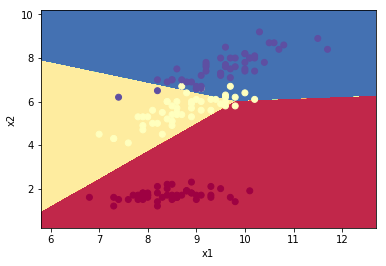

In [40]:
# Logistic regression try
import sklearn.linear_model

def plot_decision_boundary(model, X, y):
    """
    Plots learning data with model using scatter plot.
    
    model -- predict function (sample -> label)
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

# Prototype of logistic regression model for plot_decision_boudary function testing
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, Y);

plot_decision_boundary(lambda x: clf.predict(x), X.T, Y.T)

In [43]:
def layers_sizes(Xx, Yy, hidden_layers):
    """
    X -- input dataset
    Y -- labels
    hidden_layers -- vector of amounts of neurons in each hidden layer, 
                     i.e. [3,4,6] means 3 hidden layers with 3, 4 and 6 neurons accordingly
    
    Returns: array of layer sizes i.e. [34, 3, 4, 6, 2] (above example with 34 features and 2 labels dataset)
    """
    
    return [Xx.shape[1]] + hidden_layers + [Yy.shape[0]]

layers_sizes(np.array([[1,2,3],[4,5,6]]), class_to_vec(np.array([0,2])), [3,4,5])
# expected [3,3,4,5,3]

[3, 3, 4, 5, 3]

In [49]:
# force reproductible random function behaviour
np.random.seed(1)


def initialize_nn(layers_sizes):
    """
    layers_sizes -- array of sizes of each layes in neural network
    
    Returns: Complete neural network in matrix notation.
             Array of weights and biases for each layer. 
             Please note that the first layer takes the raw input - does not contain weights and biases.
    """
    result = []
    prev_size = layers_sizes[0]
    
    for idx, size in enumerate(layers_sizes[1:]):
        weights = np.random.randn(size, prev_size) * 0.01
        biases = np.zeros(shape=(size, 1))
        result += [{'weights': weights, 'biases': biases, 'layer_no': idx + 1}]
        prev_size = size
    
    return result

initialize_nn([2, 3, 4])
# expected neural network parameters constructed from two layers 
# (the first one (layer no 0) is fake - only pass input data further to the next layer)

[{'weights': array([[ 0.01624345, -0.00611756],
         [-0.00528172, -0.01072969],
         [ 0.00865408, -0.02301539]]), 'biases': array([[0.],
         [0.],
         [0.]]), 'layer_no': 1},
 {'weights': array([[ 0.01744812, -0.00761207,  0.00319039],
         [-0.0024937 ,  0.01462108, -0.02060141],
         [-0.00322417, -0.00384054,  0.01133769],
         [-0.01099891, -0.00172428, -0.00877858]]), 'biases': array([[0.],
         [0.],
         [0.],
         [0.]]), 'layer_no': 2}]

In [58]:
def sigmoid(x, derivative=False):
    """
    Source: https://gist.github.com/jovianlin/805189d4b19332f8b8a79bbd07e3f598
    """
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm


def forward_propagation(Xx, Nn, activation='sigmoid'):
    """
    Xx -- input dataset
    Nn -- Neural network parameters: array of dictionaries with weights and bayases (neural network)
    activation -- activation function used for calculation of single neuron output
    
    Returns result of forward propagation (no_of_classes, no_of_examples) and cache with results of each layer
    """
    # input dataset is the output of the first layer
    A = Xx.T
    cache = [A]
    
    for layer in Nn:
        Z = np.dot(layer['weights'], A) + layer['biases']
        if activation == 'sigmoid':
            A = sigmoid(Z)
        else:
            A = np.tanh(Z)
        cache += [A]
        
    return A, cache

X_test = np.array([[1,2,3],[1,2,3]])
Y_test = np.array([[0,1],[1,0]])
sizes = layers_sizes(X_test, Y_test, [6])
layers = initialize_nn(sizes)
R, cache = forward_propagation(X_test, layers)
R, cache
# expected result: array 3x150 (3 classes, 150 examples)

(array([[0.50116218, 0.50116218],
        [0.50187588, 0.50187588]]), [array([[1, 1],
         [2, 2],
         [3, 3]]), array([[0.49362207, 0.49362207],
         [0.49995959, 0.49995959],
         [0.5116356 , 0.5116356 ],
         [0.49443659, 0.49443659],
         [0.50643474, 0.50643474],
         [0.50407782, 0.50407782]]), array([[0.50116218, 0.50116218],
         [0.50187588, 0.50187588]])])

In [61]:
def compute_cost(R, Y):
    """
    Arguments:
    R -- results of forward propagation, shape: (no_of_classes, no_of_examples)
    Y -- labels of exmples
    """
    
    m = Y.shape[1] # number of examples
    
    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(R), Y) + np.multiply((1 - Y), np.log(1 - R))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    
    return cost

medium = compute_cost(
    np.array([[.1,.2,.3],
              [.4,.1,.4]]), 
    np.array([[0.,1.,0.],
              [1.,0.,1.]]))

big = compute_cost(
    np.array([[.1,.6,.3],
              [.8,.1,.6]]), 
    np.array([[1.,0.,1.],
              [0.,1.,0.]]))

small = compute_cost(
    np.array([[.1,.9,.1],
              [.9,.1,.9]]), 
    np.array([[0.,1.,0.],
              [1.,0.,1.]]))

assert small < medium < big
small, medium, big

(0.2107210313156526, 1.336471783812265, 3.083720788832146)

In [67]:
def backward_propagation(Nn, cache, X, Y):
    """    
    Arguments:
    Nn -- list of matrices containing layers weights and biases
    cache -- list of vectors containing output of every layer
    X -- input dataset
    Y -- dataset labels
    
    Returns:
    gradients -- list of gradients for each layer
    """
    m = X.shape[0]
    # dZ - error vector (delta)
    # calculate elta of the last layer (final output)
    dZ = list(reversed(cache))[0] - Y
    gradients = []
    
    for (layer, A) in zip(list(reversed(Nn)), list(reversed(cache))[1:]):
        dW = (1/m) * np.dot(dZ, A.T)
        dB = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        gradients = [{'dW': dW,'dB': dB}] + gradients
        dZ = np.multiply(np.dot(layer['weights'].T, dZ), 1 - np.power(A, 2))

    return gradients

# example for 2x2x1 neural network
backward_propagation(
    # nn with 2 layers
    [{'weights': np.array([[1,2],[3,4]]), 'biases': np.zeros([2,1])}, 
     {'weights': np.array([[1,2]]), 'biases': np.zeros([1,1])}],
    # three vectors with output (the very first one is input dataset)
    [np.array([[1],[2]]), np.array([[1],[2]]), np.array([[3]])],
    # X
    np.array([[1,2]]),
    # Y
    np.array([[1]])
)
# should return two matrices with gradients corresponding to weights matrices sizes

[{'dW': array([[  0.,   0.],
         [-12., -24.]]), 'dB': array([[  0.],
         [-12.]])}, {'dW': array([[2., 4.]]), 'dB': array([[2.]])}]

In [71]:
def update_parameters(Nn, gradients, learning_rate=1.2):
    """
    Updates neural network weights and biases based on gradients calculated in back-propagation process
    
    Nn -- neural network model
    gradients -- output of backpropagation
    """
    result_Nn = []
    for (layer, grad) in zip(Nn, gradients):
        layer['weights'] = layer['weights'] - learning_rate * grad['dW']
        layer['biases'] = layer['biases'] - learning_rate * grad['dB']
        result_Nn += [layer]
    return result_Nn

update_weights(
    [{'weights': np.array([[1,2],[3,4]]), 'biases': np.zeros([2,1])}, 
     {'weights': np.array([[1,2]]), 'biases': np.zeros([1,1])}],
    [{'dW': np.array([[2,3],[4,5]]), 'dB': np.zeros([2,1])}, 
     {'dW': np.array([[1,2]]), 'dB': np.zeros([1,1])}],
    1)

[{'weights': array([[-1, -1],
         [-1, -1]]), 'biases': array([[0.],
         [0.]])}, {'weights': array([[0, 0]]), 'biases': array([[0.]])}]

In [73]:
def mlp_network(X, Y, iterations = 1000, hidden_layers=[10], activation='sigmoid', learning_rate=1.2, threshold=None):
    """
    Initializes and learns neural network model based on input dataset and parameters
    X -- input dataset
    Y -- labels of input dataset
    
    Returns:
    (W, partials)
    W -- weights of optimal neural network
    partials -- 10 partial results of not-yet-fully-learned network
    """
    
    sizes = layers_sizes(X, Y, hidden_layers)
    W = initialize_nn(sizes)
    partials = []

    for i in range(iterations):
        A, cache = forward_propagation(X, W)
                
        if (i+1) % int(iterations/10) == 1:
            print('cost', i, compute_cost(A, Y))
            partials += [W]
            
        if (not threshold == None and threshold > compute_cost(A, Y)):
            break
        
        gradients = backward_propagation(W, cache, X, Y)
        
        W = update_parameters(W, gradients, learning_rate)
    
    print('cost', i, compute_cost(A, Y))
    return W, partials

optimal_W, partials = mlp_network(X, class_to_vec(Y), 1000, [6])

cost 0 2.078002929101298
cost 100 1.1286144747836115
cost 200 1.0370545495520678
cost 300 1.0472533781196351
cost 400 1.0585072357880285
cost 500 1.2950447629740345
cost 600 0.8239345182303792
cost 700 0.6064096250856831
cost 800 0.6610321370663337
cost 900 0.49059706320535024
cost 999 0.5195467380505224


/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


In [76]:
def predict(X, Nn):
    """
    X -- samples to predict
    Nn -- neural network model
    """
    results = []
    R = forward_propagation(X, Nn)[0]
    for col in R.T:
        results += [col.argmax()]
    return np.array(results)

predict(np.array([[3,4]]), optimal_W)

/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


array([2])

cost 0 2.079977279474418


/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


cost 10000 0.5379218329086362
cost 20000 0.3878691851284314
cost 30000 0.24653701350018584
cost 40000 0.19589718274577705
cost 50000 0.1772916097594012
cost 60000 0.1459342054336333
cost 70000 0.1460431444364037
cost 80000 0.1460764917520912
cost 90000 0.1460753029410436
cost 99999 0.18991990400337175


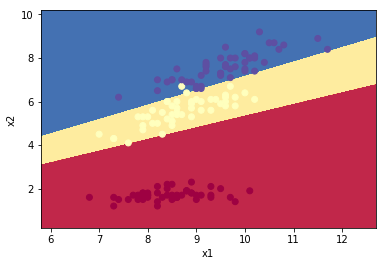

In [86]:
optimal_W, partials = mlp_network(X, class_to_vec(Y), 100000, [20,10], threshold=0.10, learning_rate=0.05)
plot_decision_boundary(lambda x: predict(x, optimal_W), X.T, Y.T)

In [19]:
def normalize(M):
    m = M - M.mean(axis=0)
    return m / np.abs(m).max(axis=0)

In [ ]:
Xl = normalize(X)
Yl = Y

nn,_ = mlp_network(Xl, class_to_vec(Yl), 100000, [6,2])
plot_decision_boundary(lambda x: predict(x, nn), Xl.T, Yl.T)

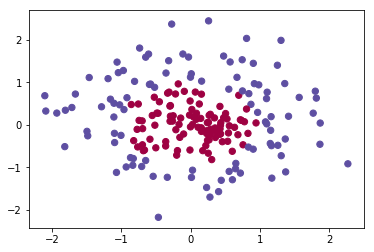

In [21]:
def load_extra_datasets():  
    N = 200
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.7, n_samples=N, n_features=2, n_classes=2,  shuffle=True, random_state=None)
    return gaussian_quantiles

Xg, Yg = load_extra_datasets()
plt.scatter(Xg.T[0, :], Xg.T[1, :], c=Yg, s=40, cmap=plt.cm.Spectral);


cost 0 1.3864459190798408


/Users/mk/repos/inshorts-nlp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


cost 10000 1.1572607865161912
cost 20000 0.7685352673910173
cost 30000 0.6696265318073372
cost 33216 0.24900431129225847


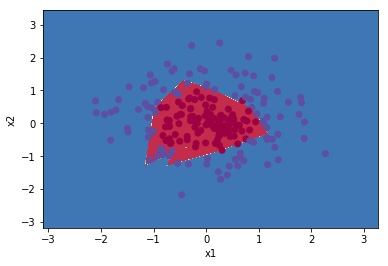

In [24]:
Xl = Xg
Yl = Yg

nn,_ = mlp_network(Xl, class_to_vec(Yl), 100000, [20,10], learning_rate=2, threshold=0.25)
plot_decision_boundary(lambda x: predict(x, nn), Xl.T, Yl.T)

In [23]:
# mmnist data


[{'weights': array([[ -2079.04172917,   -265.23674171],
         [ 77430.63738941, -26483.31659063],
         [ 11776.85885162,  -4426.46580095],
         [-82601.72346106, 122696.04820291],
         [ 88338.40271364, -38192.28464672],
         [ 77868.53841696, -33197.69939826],
         [ 81321.32488237, -34880.57641892],
         [111813.00859535, -52462.38610367],
         [106168.42757699, -48765.49902586],
         [-21543.48098803,  19376.10283174],
         [ 72180.98512881, -30704.10960316],
         [ 75357.00225813, -32065.36591433],
         [ 76929.8686856 , -33030.29981537],
         [ -9188.09609959,  10305.8525884 ],
         [ 74265.87981008, -31715.7100049 ],
         [ 74123.47769544, -31665.55901682],
         [ 73328.43466677, -31288.77419963],
         [ 75951.24325248, -32543.38013586],
         [ 94555.33204989, -41916.63303671],
         [ 75275.51480109, -32198.37875763]]),
  'biases': array([[  -3862.67451985],
         [ -79479.37802651],
         [ -12207.2